# Open problems 6b

Consider the extended Galactic source RX J1713-3946, located at 1 kpc from us. Its coordinates are l, b = 347.313895°, -0.459872° and its spectrum can be modeled with a powerlaw of $\Gamma=2.06$ and amplitude of $2.3\times10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$ at 1 TeV.
Simulate it and fit the sampled events to estimate the constraints on the size of its morpholgy. Then, move the source to larger distances, rescaling the powerlaw amplitude and the source size accordingly, and estimate its morphology. Calculate how the constraints on the size change with the distance. For simplicity, consider an exposure time of 10 hours and fix the source coordinates when fitting the model.

### 1. Proceed with the imports:

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import time
import numpy as np
import threading
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.io import fits
from astropy.time import Time
from regions import CircleSkyRegion, PointSkyRegion
from gammapy.data import Observation, observatory_locations, FixedPointingInfo, PointingMode
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    LightCurveTemplateTemporalModel,
    DiskSpatialModel,
    ConstantTemporalModel,
     PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models
)

Let's simulate the source RX J1713-3946. This is located at 1 kpc of distance, at coordinates l, b = 347.313895°, -0.459872°. Its spectrum can be modeled with a powerlaw of $\Gamma=2.06$ and amplitude of $2.3\times10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$ at 1 TeV. 

The integrated flux is: 
$F_{1~\text{kpc}} = \int_{0.01~\text{TeV}}^{10~\text{TeV}} N_{1~\text{kpc}} \cdot (\cfrac{E}{E_0})^{-\Gamma} dE$

from which we can estimate the luminosity, which has to be unvariant for the distance:

$L_{\gamma} = F_{1~\text{kpc}} \cdot 4 \cdot \pi \cdot D_{1~\text{kpc}}^2$

$L_{\gamma} = F_D \cdot 4 \cdot \pi \cdot D^2$


Therefore, the powerlaw amplitude $N_D$ scales with the distance as:

$N_D = N_{1~\text{kpc}} \cdot (\cfrac{1~\text{kpc}}{D})^2$

where $N_{1~\text{kpc}}$ is the amplitude at 1 TeV.

### 2. Calculate the amplitudes for different distances:

In [2]:
# let's determine the powerlaw amplitude for the different distances:

distances = [1, 2, 3, 4, 5, 7, 10, 15] * u.kpc

# Utilise the equation N_D
amplitudes = 2.3*10**-11 * u.Unit("cm-2 s-1 TeV-1") * (1* u.kpc/distances)**2

### 3. calculate the source radius
If the source has a disk morphology with radius $r=0.5$° at 1 kpc, its real size is 8.73e-3 kpc. 
The scaling relation with the distance is:

$r = \text{arctan}(0.00873~\text{kpc} / D)$

Calculate the source radius for different distances:

In [3]:
# let's determine the size of the radius for the different distances:
radius = np.atan(8.73e-3 *u.kpc / distances).to("deg")

### 4. Define the energy (reco and true) axes:

In [4]:
# create the observation and the dataset
energy_axis = MapAxis.from_energy_bounds("0.05 TeV", "70 TeV", nbin=5, per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds("0.01 TeV", "90 TeV", nbin=10, per_decade=True, name="energy_true")

### 5. Set the source coordinates and the pointing direction:

In [5]:
target = SkyCoord("347.313895 deg", "-0.459872 deg", unit="deg", frame="galactic")

# You saw how to do this in 6a!
pointing_position = target.directional_offset_by(position_angle = 0 * u.deg, separation = 0.5 * u.deg)
pointing = FixedPointingInfo(fixed_icrs=pointing_position.icrs) 

### 6. Load the IRF with the `load_irf_dict_from_file` function:

In [6]:
path = "$GAMMAPY_DATA/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
irf = load_irf_dict_from_file(path)

### 7. Define the geometry (assume a square with 2.5° by side) and create the `MapDataset`:

In [7]:
geom = WcsGeom.create(
            skydir=target,
            width=(2.5, 2.5), #deg
            binsz=0.02, #deg
            frame="icrs",
            axes=[energy_axis],
            )

# You could also set a migra axis. 
# Set a migra axis only if you want simulate DL3 events
migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

empty = MapDataset.create(
            geom,
            energy_axis_true=energy_axis_true,
            migra_axis=migra_axis,
            name="my-dataset",
            )

### 8. Create the `Observation` object (assume an exposure of 10 hr) and the `MapDataset` with the `MapDatasetMaker` class:

In [8]:
# let's create the observation object:
livetime = 10 * u.hr
deadtime = 0.05
print(f"Simulation for exposure: {livetime} with deadtime={deadtime}")

time_ref = Time("2025-11-05T00:00:00", format="isot", scale="utc")
observation = Observation.create(obs_id="0001",
                pointing=pointing,
                livetime=livetime,
                deadtime_fraction=0.05,
                irfs=irf,
                reference_time=time_ref,
                )

maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

Simulation for exposure: 10.0 h with deadtime=0.05


### 9. Create the background model, which will be the same for all simulated models. Use the background from the IRF with `FoVBackgroundModel`:

In [9]:
# let's create the bkg model 

bkg = FoVBackgroundModel(dataset_name="my-dataset")

### 10. Let's loop over the different distances, i.e. different amplitudes and radius, simulate the events `MapDataset.fake()`, fit them (with the `Fit` class) and finally estimate the size of the source and its uncertainty.

In [10]:
sigmas, errors = [], []
for N, r, dist in zip(amplitudes, radius, distances):
    print(f"Calculation for a distance of {dist}: {N} and {r}")

    # choose a disk model with the radius 
    spatial_model =  DiskSpatialModel(
                            lon_0=target.transform_to('icrs').ra,
                            lat_0=target.transform_to('icrs').dec,
                            r_0=r,
                            frame="icrs",
                            )

    spectral_model = PowerLawSpectralModel(index=2.06, amplitude=N, reference="1 TeV")

    source_model = SkyModel(spectral_model=spectral_model,
                        spatial_model=spatial_model,
                        name="fake_src")

    full_model = Models([source_model, bkg])

    dataset.models = full_model.copy()

    dataset.fake()

    dataset.models.parameters["lon_0"].frozen = True
    dataset.models.parameters["lat_0"].frozen = True

    fit = Fit()
    minuit_opts = {"strategy": 2}
    fit.backend = "minuit"
    fit.optimize_opts = minuit_opts
    result = fit.run(dataset)

    sigmas.append(result.models[0].spatial_model.r_0.value)
    errors.append(result.models[0].spatial_model.r_0.error)
    print(result)

Calculation for a distance of 1.0 kpc: 2.2999999999999998e-11 1 / (TeV s cm2) and 0.5001794486986738 deg
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 142
	total stat : -1183033.45

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 2.0 kpc: 5.7499999999999995e-12 1 / (TeV s cm2) and 0.25009448921381644 deg
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 168
	total stat : -1123878.78

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Calculation for a distance of 3.0 kpc: 2.5555555555555553e-12 1 / (TeV s cm2) and 0.16673024775466197 deg
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message  

### 11. Plot our results as a function of the distance:

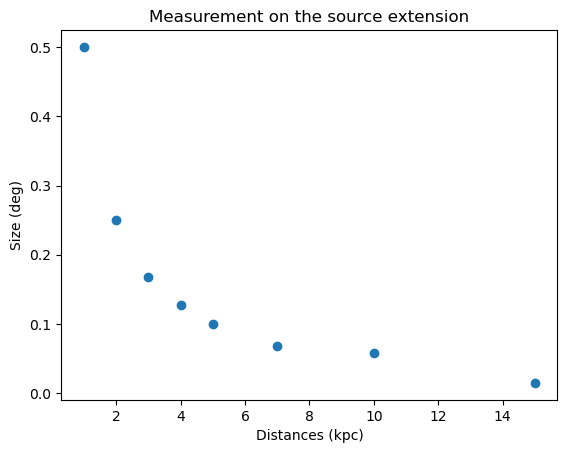

In [11]:
plt.errorbar(distances, np.array(sigmas)*u.deg, yerr=np.array(errors)*u.deg, fmt="o");
plt.xlabel("Distances (kpc)")
plt.ylabel("Size (deg)")
plt.title("Measurement on the source extension");